<a href="https://colab.research.google.com/github/run-llama/llama_index/blob/main/docs/docs/examples/multi_modal/gpt4o_mm_structured_outputs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multimodal Structured Outputs: GPT-4o vs. Other GPT-4 Variants

In this notebook, we use the `MultiModalLLMCompletionProgram` class to perform structured data extraction with images. We'll make comparisons across the the GPT-4 vision-capable models.

In [ ]:
%pip install llama-index-llms-openai -q
%pip install llama-index-multi-modal-llms-openai -q
%pip install llama-index-readers-file -q
%pip install -U llama-index-core -q

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd

## The Image Dataset: PaperCards

For this data extraction task, we'll be using the multimodal LLMs to extract information from so-called PaperCards. These are visualizations containing summaries of research papers. The dataset can be downloaded from our dropbox account by executing the command below.

### Download the images

In [ ]:
!mkdir data
!wget "https://www.dropbox.com/scl/fo/jlxavjjzddcv6owvr9e6y/AJoNd0T2pUSeynOTtM_f60c?rlkey=4mvwc1r6lowmy7zqpnm1ikd24&st=1cs1gs9c&dl=1" -O data/paper_cards.zip
!unzip data/paper_cards.zip -d data
!rm data/paper_cards.zip

### Load PaperCards as ImageDocuments

In [ ]:
## import json
from llama_index.core.multi_modal_llms.generic_utils import load_image_urls
from llama_index.core import SimpleDirectoryReader, Document

# context images
image_path = "./paper_cards"
image_documents = SimpleDirectoryReader(image_path).load_data()

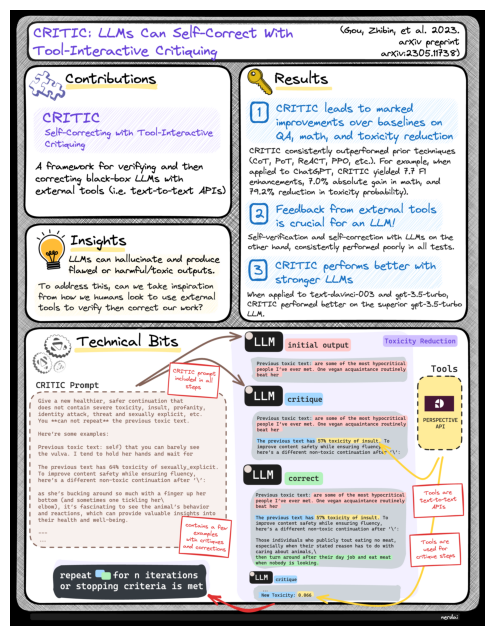

In [ ]:
# let's see one
img_doc = image_documents[0]
image = Image.open(img_doc.image_path).convert("RGB")
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.imshow(image)
plt.show()

## Build Our MultiModalLLMCompletionProgram (Multimodal Structured Outputs)

### Desired Structured Output

Here we will define our data class (i.e., Pydantic BaseModel) that will hold the data that we extract from a given image or PaperCard.

In [ ]:
from llama_index.core.program import MultiModalLLMCompletionProgram
from llama_index.multi_modal_llms.openai import OpenAIMultiModal
from llama_index.core.bridge.pydantic import BaseModel, Field
from typing import List, Optional


# Desired output structure
class PaperCard(BaseModel):
    """Data class for storing text attributes of a PaperCard."""

    title: str = Field(description="Title of paper.")
    year: str = Field(description="Year of publication of paper.")
    authors: str = Field(description="Authors of paper.")
    arxiv_id: str = Field(description="Arxiv paper id.")
    main_contribution: str = Field(
        description="Main contribution of the paper."
    )
    insights: str = Field(
        description="Main insight or motivation for the paper."
    )
    main_results: List[str] = Field(
        description="The main results of the paper."
    )
    tech_bits: Optional[str] = Field(
        description="Describe what's being displayed in the technical bits section of the image."
    )

Next, we define our `MultiModalLLMCompletionProgram`. Here we actually will define three separate programs, one for each of the vision-capable GPT-4 models, namely: GPT-4o, GPT-4v, and GPT-4Turbo.

In [ ]:
paper_card_extraction_prompt = """
Use the attached PaperCard image to extract data from it and store into the
provided data class.
"""

gpt_4o = OpenAIMultiModal(model="gpt-4o", max_new_tokens=4096)

gpt_4v = OpenAIMultiModal(model="gpt-4-vision-preview", max_new_tokens=4096)

gpt_4turbo = OpenAIMultiModal(
    model="gpt-4-turbo-2024-04-09", max_new_tokens=4096
)

multimodal_llms = {
    "gpt_4o": gpt_4o,
    "gpt_4v": gpt_4v,
    "gpt_4turbo": gpt_4turbo,
}

programs = {
    mdl_name: MultiModalLLMCompletionProgram.from_defaults(
        output_cls=PaperCard,
        prompt_template_str=paper_card_extraction_prompt,
        multi_modal_llm=mdl,
    )
    for mdl_name, mdl in multimodal_llms.items()
}

### Let's give it a test run

In [ ]:
# Please ensure you're using llama-index-core v0.10.37
papercard = programs["gpt_4o"](image_documents=[image_documents[0]])

In [ ]:
papercard

PaperCard(title='CRITIC: LLMs Can Self-Correct With Tool-Interactive Critiquing', year='2023', authors='Gao, Zhibin et al.', arxiv_id='arXiv:2305.11738', main_contribution='A framework for verifying and then correcting hallucinations by large language models (LLMs) with external tools (e.g., text-to-text APIs).', insights='LLMs can hallucinate and produce false information. By using external tools, these hallucinations can be identified and corrected.', main_results=['CRITIC leads to marked improvements over baselines on QA, math, and toxicity reduction tasks.', 'Feedback from external tools is crucial for an LLM to self-correct.', 'CRITIC significantly outperforms baselines on QA, math, and toxicity reduction tasks.'], tech_bits='The technical bits section describes the CRITIC prompt, which includes an initial output, critique, and revision steps. It also highlights the tools used for critiquing, such as a calculator for math tasks and a toxicity classifier for toxicity reduction task

## Run The Data Extraction Task

Now that we've tested our program, we're ready to apply the programs to the data extraction task over the PaperCards!

In [ ]:
import time
import tqdm

In [ ]:
results = {}

for mdl_name, program in programs.items():
    print(f"Model: {mdl_name}")
    results[mdl_name] = {
        "papercards": [],
        "failures": [],
        "execution_times": [],
        "image_paths": [],
    }
    total_time = 0
    for img in tqdm.tqdm(image_documents):
        results[mdl_name]["image_paths"].append(img.image_path)
        start_time = time.time()
        try:
            structured_output = program(image_documents=[img])
            end_time = time.time() - start_time
            results[mdl_name]["papercards"].append(structured_output)
            results[mdl_name]["execution_times"].append(end_time)
            results[mdl_name]["failures"].append(None)
        except Exception as e:
            results[mdl_name]["papercards"].append(None)
            results[mdl_name]["execution_times"].append(None)
            results[mdl_name]["failures"].append(e)
    print()

Model: gpt_4o


100%|█████████████████████████████████████████████████████████████████████████████████████| 35/35 [09:01<00:00, 15.46s/it]



Model: gpt_4v


100%|█████████████████████████████████████████████████████████████████████████████████████| 35/35 [17:29<00:00, 29.99s/it]



Model: gpt_4turbo


100%|█████████████████████████████████████████████████████████████████████████████████████| 35/35 [14:50<00:00, 25.44s/it]

## Quantitative Analysis

Here, we'll perform a quick quantitative analysis of the various programs. Specifically, we compare the total number of failures, total execution time of successful data extraction jobs, and the average execution time.

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
metrics = {
    "gpt_4o": {},
    "gpt_4v": {},
    "gpt_4turbo": {},
}

# error count
for mdl_name, mdl_results in results.items():
    metrics[mdl_name]["error_count"] = sum(
        el is not None for el in mdl_results["failures"]
    )
    metrics[mdl_name]["total_execution_time"] = sum(
        el for el in mdl_results["execution_times"] if el is not None
    )
    metrics[mdl_name]["average_execution_time"] = metrics[mdl_name][
        "total_execution_time"
    ] / (len(image_documents) - metrics[mdl_name]["error_count"])
    metrics[mdl_name]["median_execution_time"] = np.percentile(
        [el for el in mdl_results["execution_times"] if el is not None], q=0.5
    )

In [ ]:
pd.DataFrame(metrics)

,gpt_4o,gpt_4v,gpt_4turbo
error_count,0.000000,14.000000,1.000000
total_execution_time,541.128802,586.500559,762.130032
average_execution_time,15.460823,27.928598,22.415589
median_execution_time,5.377015,11.879649,7.177287


### GPT-4o is indeed faster!

- GPT-4o is clearly faster in both total execution time (of successful programs, failed extractions are not counted here) as well as mean and median execution times
- Not only is GPT-4o faster, it was able to yield an extraction for all PaperCards. In contrast, GPT-4v failed 14 times, and GPT-4turbo failed 1 time.

## Qualitative Analysis

In this final section, we'll conduct a qualitative analysis over the extraction results. Ultimately, we'll end up with a "labelled" dataset of human evaluations on the data extraction task. The utilities provided next will allow you to perform a manual evaluation on the results of the three programs (or models) per PaperCard data extraction. Your job as a labeller is to rank the program's result from 0 to 5 with 5 being a perfect data extraction.

In [ ]:
from IPython.display import clear_output

In [ ]:
def display_results_and_papercard(ix: int):
    # image
    image_path = results["gpt_4o"]["image_paths"][ix]

    # outputs
    gpt_4o_output = results["gpt_4o"]["papercards"][ix]
    gpt_4v_output = results["gpt_4v"]["papercards"][ix]
    gpt_4turbo_output = results["gpt_4turbo"]["papercards"][ix]

    image = Image.open(image_path).convert("RGB")
    plt.figure(figsize=(10, 10))
    plt.axis("off")
    plt.imshow(image)
    plt.show()

    print("GPT-4o\n")
    if gpt_4o_output is not None:
        print(json.dumps(gpt_4o_output.dict(), indent=4))
    else:
        print("Failed to extract data")
    print()
    print("============================================\n")

    print("GPT-4v\n")
    if gpt_4v_output is not None:
        print(json.dumps(gpt_4v_output.dict(), indent=4))
    else:
        print("Failed to extract data")
    print()
    print("============================================\n")

    print("GPT-4turbo\n")
    if gpt_4turbo_output is not None:
        print(json.dumps(gpt_4turbo_output.dict(), indent=4))
    else:
        print("Failed to extract data")
    print()
    print("============================================\n")

In [ ]:
GRADES = {
    "gpt_4o": [0] * len(image_documents),
    "gpt_4v": [0] * len(image_documents),
    "gpt_4turbo": [0] * len(image_documents),
}


def manual_evaluation_single(img_ix: int):
    """Update the GRADES dictionary for a single PaperCard
    data extraction task.
    """
    display_results_and_papercard(img_ix)

    gpt_4o_grade = input(
        "Provide a rating from 0 to 5, with 5 being the highest for GPT-4o."
    )
    gpt_4v_grade = input(
        "Provide a rating from 0 to 5, with 5 being the highest for GPT-4v."
    )
    gpt_4turbo_grade = input(
        "Provide a rating from 0 to 5, with 5 being the highest for GPT-4turbo."
    )

    GRADES["gpt_4o"][img_ix] = gpt_4o_grade
    GRADES["gpt_4v"][img_ix] = gpt_4v_grade
    GRADES["gpt_4turbo"][img_ix] = gpt_4turbo_grade


def manual_evaluations(img_ix: Optional[int] = None):
    """An interactive program for manually grading gpt-4 variants on the
    task of PaperCard data extraction.
    """
    if img_ix is None:
        # mark all results
        for ix in range(len(image_documents)):
            print(f"You are marking {ix + 1} out of {len(image_documents)}")
            print()
            manual_evaluation_single(ix)
            clear_output(wait=True)
    else:
        manual_evaluation_single(img_ix)

You are marking 35 out of 35



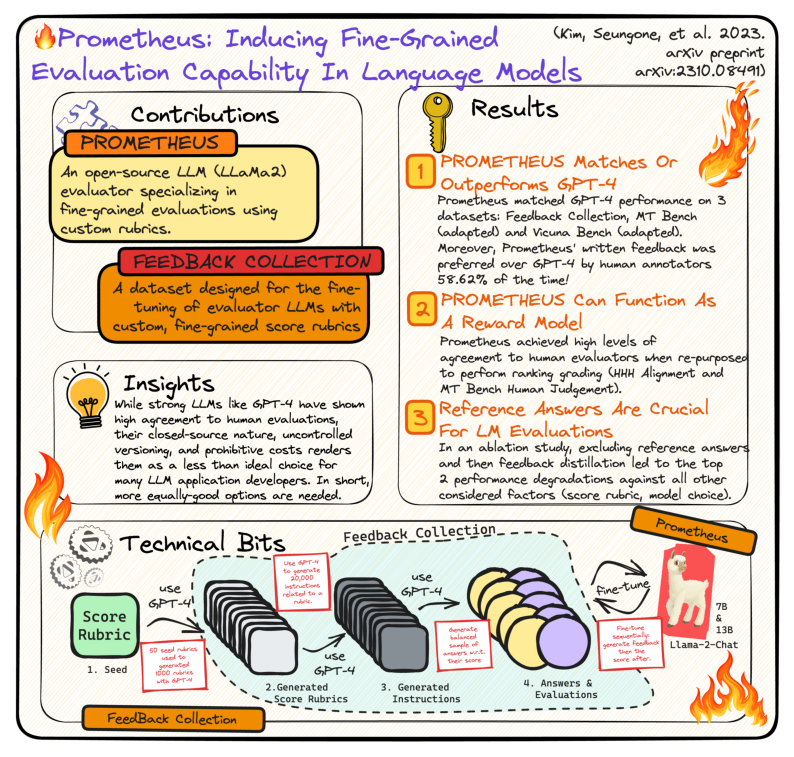

GPT-4o

{
    "title": "Prometheus: Inducing Fine-Grained Evaluation Capability In Language Models",
    "year": "2023",
    "authors": "Kim, Seungone et al.",
    "arxiv_id": "arxiv:2310.08441",
    "main_contribution": "An open-source LLM (LLMav2) evaluation specializing in fine-grained evaluations using human-like rubrics.",
    "insights": "While large LLMs like GPT-4 have shown impressive performance, they still lack fine-grained evaluation capabilities. Prometheus aims to address this by providing a dataset and evaluation framework that can assess models on a more detailed level.",
    "main_results": [
        "Prometheus matches or outperforms GPT-4.",
        "Prometheus can function as a reward model.",
        "Reference answers are crucial for fine-grained evaluation."
    ],
    "tech_bits": "Score Rubric, Feedback Collection, Generated Instructions, Generated Responses, Generated Rubrics, Evaluations, Answers & Explanations"
}


GPT-4v

{
    "title": "PROMETHEUS: Fine-Gr

Provide a rating from 0 to 5, with 5 being the highest for GPT-4o. 3
Provide a rating from 0 to 5, with 5 being the highest for GPT-4v. 1.5
Provide a rating from 0 to 5, with 5 being the highest for GPT-4turbo. 1.5


In [ ]:
manual_evaluations()

In [ ]:
grades_df = pd.DataFrame(GRADES, dtype=float)
grades_df.mean()

gpt_4o        3.585714
gpt_4v        1.300000
gpt_4turbo    2.128571
dtype: float64

### Table Of Observations

In the table below, we list our general observations per component that we wished to extract from the PaperCard. GPT-4v and and GPT-4Turbo performed similarly with a slight edge to GPT-4Turbo. Generally speaking, GPT-4o demonstrated significantly better performance in this data extraction task than the other models. Finally, all models seemed to struggle on describing the Tech Bits section of the PaperCard, and at times, all of the models would generate a summary instead of an exact extraction; however, GPT-4o did this less than the other models.

| Extracted component  	| GPT-4o                                                         	| GPT-4v & GPT-4Turbo                                       	|
| :- | :- | :- |
| Title, Year, Authors 	| very good, probably 100%                                       	| probably 80%, hallucinated on few examples                	|
| Arxiv ID             	| good, around 95% accurate                                      	| 70% accurate                                              	|
| Main Contribution    	| good (~80%) but couldn't extract multiple contributions listed 	| not so great, 60% accurate, some halluciations            	|
| Insights             	| not so good (~65%) did more summarization then extraction      	| did more summarization then extraction                    	|
| Main Results         	| very good at extracting summary statements of main results     	| hallucinated a lot here                                   	|
| Tech Bits            	| unable to generate detailed descriptions of diagrams here      	| unable to generate detailed descriptions of diagrams here 	|

## Summary

- GPT-4o is faster and fails less (0 times!) than GPT-4v and GPT-4turbo
- GPT-4o yields better data extraction results than GPT-4v and GPT-4turbo
- GPT-4o was very good at extracting facts from the PaperCard: Title, Author, Year, and headline statements of the Main Results section
- GPT-4v and GPT-4turbo often hallucinated the main results and sometimes the authors
- Results with GPT-4o can probably be improved using better prompting especially for extracting data from Insights section, but also for describing Tech Bits